I have downloaded a dataset from kaggle that focuses on health insurance claims. 
This dataset focuses on provider fraud within Medicare. The dataset can be found on <https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis?select=Train_Outpatientdata-1542865627584.csv>

The object of this validation project is to predict fraudulent claims. 

Healthcare fraud doesn't just happen with it's policy holders but it also exists with medical practices. It ranges from: 
-billing for services that wrre not provided, misrepresenting the service provided, duplicated submissions for the same service, up charging for a more expensive service that was not actually provided and billing an insurance company for something that is covered in order to cover the costs of something the claiment does not have coverage for. 
    

My data file holds separate csvs' that contain separate train and test files. These are split up into beneficiary and outpatient data. 
I will explore and give a glimpse at each file, conduct exploratory data analysis and identify the biggest factors in fradulent detection


# Data Cleaning & Understanding

In [1]:
conda install -c conda-forge pandas-profiling


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
#import all the necessary libraries and tools
import numpy as np

import pandas as pd
import pandas_profiling as profile #this is to check the correlation and data distribution

import scipy as sc
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import warnings #this is to omit all warning notifications due to large files
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import pickle

import tensorflow as tf

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 2

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Labels = ['Normal', 'Fraud']

Using TensorFlow backend.


In [3]:
#let's take a look at the datasets

train = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train-1542865627584.csv')
train_outpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Outpatientdata-1542865627584.csv')
train_inpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Inpatientdata-1542865627584.csv')
train_beneficiary = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Train_Beneficiarydata-1542865627584.csv')

test = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test-1542969243754.csv')
test_beneficiary = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Beneficiarydata-1542969243754.csv')
test_inpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Inpatientdata-1542969243754.csv')
test_outpatient = pd.read_csv('/Users/aqureshi/Desktop/DS 021720/axa_validation_project/insuranceclaims/data/Test_Outpatientdata-1542969243754.csv')

In [4]:
train_outpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [5]:
train_outpatient.shape

(517737, 27)

In [6]:
train_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [7]:
train_inpatient.shape

(40474, 30)

In [8]:
train_beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [9]:
test_beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,...,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,...,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaN,2,1,Y,45,780,12,12,...,1,2,1,2,2,2,21260,2136,120,100


The beneficiary data seems to be more informative of specific diseases, disorders and severity of each claimant. This is either a 1 or 2. We should change this to a 0 for negative and 1 for positive. 

In [10]:
train_beneficiary = train_beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease':2, 'ChronicCond_Cancer':2, 'ChronicCond_ObstrPulmonary':2, 'ChronicCond_Depression':2, 'ChronicCond_Diabetes':2, 'ChronicCond_IschemicHeart':2, 'ChronicCond_Osteoporasis':2, 'ChronicCond_rheumatoidarthritis':2, 'ChronicCond_stroke':2}, 0)
train_beneficiary = train_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)
test_beneficiary = test_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)
test_beneficiary = test_beneficiary.replace({'ChronicCond_Alzheimer':2, 'ChronicCond_Heartfailure':2, 'ChronicCond_KidneyDisease':2, 'ChronicCond_Cancer':2, 'ChronicCond_ObstrPulmonary':2, 'ChronicCond_Depression':2, 'ChronicCond_Diabetes':2, 'ChronicCond_IschemicHeart':2, 'ChronicCond_Osteoporasis':2, 'ChronicCond_rheumatoidarthritis':2, 'ChronicCond_stroke':2}, 0)
test_beneficiary = test_beneficiary.replace({'RenalDiseaseIndicator':'Y'}, 1)

In [11]:
#let's make sure this has been changed
test_beneficiary.head(1)
train_beneficiary.head(1)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,0,1,1,36000,3204,60,70


In [12]:
train_beneficiary.shape

(138556, 25)

In [13]:
#let's check the data types for the train sets. 
print("Train Inpatient Data Types:", train_inpatient.dtypes)
print("Train Outpaitet Data Types:", train_outpatient.dtypes)
print("Train bBeneficiary Data Types:", train_beneficiary.dtypes)

Train Inpatient Data Types: BeneID                     object
ClaimID                    object
ClaimStartDt               object
ClaimEndDt                 object
Provider                   object
InscClaimAmtReimbursed      int64
AttendingPhysician         object
OperatingPhysician         object
OtherPhysician             object
AdmissionDt                object
ClmAdmitDiagnosisCode      object
DeductibleAmtPaid         float64
DischargeDt                object
DiagnosisGroupCode         object
ClmDiagnosisCode_1         object
ClmDiagnosisCode_2         object
ClmDiagnosisCode_3         object
ClmDiagnosisCode_4         object
ClmDiagnosisCode_5         object
ClmDiagnosisCode_6         object
ClmDiagnosisCode_7         object
ClmDiagnosisCode_8         object
ClmDiagnosisCode_9         object
ClmDiagnosisCode_10        object
ClmProcedureCode_1        float64
ClmProcedureCode_2        float64
ClmProcedureCode_3        float64
ClmProcedureCode_4        float64
ClmProcedureCode_5  

## Feature Engineering
I would like to format the Date of Death and Date of Birth to say the age and not just the date

In [14]:
#let's create an age column 
train_beneficiary['DOB'] = pd.to_datetime(train_beneficiary['DOB'], format = '%Y-%m-%d')
train_beneficiary['DOD'] = pd.to_datetime(train_beneficiary['DOD'], format = '%Y-%m-%d', errors='ignore')
train_beneficiary['Age'] = round(((train_beneficiary['DOD'] - train_beneficiary['DOB']).dt.days)/365)

test_beneficiary['DOB'] = pd.to_datetime(test_beneficiary['DOB'], format = '%Y-%m-%d')
test_beneficiary['DOD'] = pd.to_datetime(test_beneficiary['DOD'], format = '%Y-%m-%d', errors='ignore')
test_beneficiary['Age'] = round(((test_beneficiary['DOD'] - test_beneficiary['DOB']).dt.days)/365)

In [15]:
#It seems that the last date of death recorded was in 2009. This means that this dataset is not that recent. Let's calculate the age for those who died in 09.
train_beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01', format = '%Y-%m-%d') - train_beneficiary['DOB']).dt.days)/365), inplace=True)

test_beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01', format = '%Y-%m-%d') - test_beneficiary['DOB']).dt.days)/365), inplace=True)

In [16]:
train_beneficiary.head(2)
test_beneficiary.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,0,1,1,36000,3204,60,70,67.0
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,1,0,1,1,0,0,0,1490,160,69.0


In [17]:
#let's add another column that shows whether a claimant is dead or alive
train_beneficiary.loc[train_beneficiary.DOD.isna(), 'IsDead']=0
train_beneficiary.loc[train_beneficiary.DOD.notna(), 'IsDead']=1
train_beneficiary.loc[:,'IsDead'].head(7)

test_beneficiary.loc[test_beneficiary.DOD.isna(),'IsDead']=0
test_beneficiary.loc[test_beneficiary.DOD.notna(), 'IsDead']=1
test_beneficiary.loc[:, 'IsDead'].head(7)

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: IsDead, dtype: float64

## Inpatient Data


In [18]:
train_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [19]:
test_inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,...,5990,570,41071,4280,4443.0,5849.0,NaN,NaN,NaN,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,...,4549,29570,34831,NaN,5551.0,NaN,NaN,NaN,NaN,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,...,78650,7813,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,...,4254,41400,5849,41401,8152.0,3320.0,NaN,NaN,NaN,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,...,V6109,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_inpatient.isna().sum()
test_inpatient.isna().sum()

BeneID                       0
ClaimID                      0
ClaimStartDt                 0
ClaimEndDt                   0
Provider                     0
InscClaimAmtReimbursed       0
AttendingPhysician          31
OperatingPhysician        3962
OtherPhysician            8538
AdmissionDt                  0
ClmAdmitDiagnosisCode        0
DeductibleAmtPaid          196
DischargeDt                  0
DiagnosisGroupCode           0
ClmDiagnosisCode_1           0
ClmDiagnosisCode_2          54
ClmDiagnosisCode_3         169
ClmDiagnosisCode_4         404
ClmDiagnosisCode_5         719
ClmDiagnosisCode_6        1197
ClmDiagnosisCode_7        1736
ClmDiagnosisCode_8        2360
ClmDiagnosisCode_9        3238
ClmDiagnosisCode_10       8664
ClmProcedureCode_1        4118
ClmProcedureCode_2        8297
ClmProcedureCode_3        9328
ClmProcedureCode_4        9522
ClmProcedureCode_5        9549
ClmProcedureCode_6        9551
dtype: int64

There are a lot of null values within the dataset

## Feature Engineering 
add a column to show the number of days a claimant was admitted in hospital


In [21]:
#For inpatients the minimum stay is 1 day. We will adjust the inpatient data to say at least one day of admission
train_inpatient['AdmissionDt'] = pd.to_datetime(train_inpatient['AdmissionDt'], format = '%Y-%m-%d')
train_inpatient['DischargeDt'] = pd.to_datetime(train_inpatient['DischargeDt'], format ='%Y-%m-%d')
train_inpatient['DaysAdmitted'] = ((train_inpatient['DischargeDt'] - train_inpatient['AdmissionDt']).dt.days)+1

test_inpatient['AdmissionDt'] = pd.to_datetime(test_inpatient['AdmissionDt'], format = '%Y-%m-%d')
test_inpatient['DischargeDt'] = pd.to_datetime(test_inpatient['DischargeDt'], format = '%Y-%m-%d')
test_inpatient['DaysAdmitted'] =((test_inpatient['DischargeDt'] - test_inpatient['AdmissionDt']).dt.days)+1

In [22]:
#let's have a look at tthe most time spent admitted and the least time spent
print(' Minimum days admitted train:-', train_inpatient.DaysAdmitted.min())
print('Maxmium days admitted train:-', train_inpatient.DaysAdmitted.max())
train_inpatient.DaysAdmitted.isnull().sum() #checking null values

print('Minimum days admitted test:-', test_inpatient.DaysAdmitted.min())
print('Maximum days admitted test:-', test_inpatient.DaysAdmitted.max())
test_inpatient.DaysAdmitted.isnull().sum() #checking null values

 Minimum days admitted train:- 1
Maxmium days admitted train:- 36
Minimum days admitted test:- 1
Maximum days admitted test:- 36


0

# Outpatient Data Understanding


In [23]:
#chekcing total null values
train_outpatient.isna().sum()
test_outpatient.isna().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician           316
OperatingPhysician        104237
OtherPhysician             78222
ClmDiagnosisCode_1          2578
ClmDiagnosisCode_2         47731
ClmDiagnosisCode_3         76575
ClmDiagnosisCode_4         95371
ClmDiagnosisCode_5        107875
ClmDiagnosisCode_6        114035
ClmDiagnosisCode_7        117871
ClmDiagnosisCode_8        120310
ClmDiagnosisCode_9        122278
ClmDiagnosisCode_10       125578
ClmProcedureCode_1        125807
ClmProcedureCode_2        125832
ClmProcedureCode_3        125839
ClmProcedureCode_4        125841
ClmProcedureCode_5        125841
ClmProcedureCode_6        125841
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     100036
dtype: int64

## Train and Data Exploration and Understanding

In [24]:
print('Shape of Train:', train.shape)
print('Shape of Train Beneficiary:', train_beneficiary.shape)
print('Shape of Train Inpatient:', train_inpatient.shape)
print('Shape of Train Outpatient:', train_outpatient.shape)

Shape of Train: (5410, 2)
Shape of Train Beneficiary: (138556, 27)
Shape of Train Inpatient: (40474, 31)
Shape of Train Outpatient: (517737, 27)


In [25]:
print('Shape of Test:', test.shape)
print('Shape of Test Beneficiary:', test_beneficiary.shape)
print('Shape of Test Inpatient:', test_inpatient.shape)
print('Shape of Test Outpatient:', test_outpatient.shape)

Shape of Test: (1353, 1)
Shape of Test Beneficiary: (63968, 27)
Shape of Test Inpatient: (9551, 31)
Shape of Test Outpatient: (125841, 27)


In [26]:
train_outpatient.columns #lets have a look at the columns to see what datasets we can merge

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')

In [27]:
train_inpatient.columns


Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'DaysAdmitted'],
      dtype='object')

### Merge inpatient and outpaitent sets

In [28]:
train_inandout = pd.merge(train_outpatient, train_inpatient, left_on=['BeneID',
                                                                      'ClaimID', 
                                                                      'ClaimStartDt', 
                                                                      'Provider', 
                                                                      'InscClaimAmtReimbursed', 
                                                                      'AttendingPhysician', 
                                                                      'OperatingPhysician', 
                                                                      'OtherPhysician', 
                                                                      'ClmDiagnosisCode_1', 
                                                                      'ClmDiagnosisCode_2', 
                                                                      'ClmDiagnosisCode_3', 
                                                                      'ClmDiagnosisCode_4', 
                                                                      'ClmDiagnosisCode_5', 
                                                                      'ClmDiagnosisCode_6', 
                                                                      'ClmDiagnosisCode_7', 
                                                                      'ClmDiagnosisCode_8', 
                                                                      'ClmDiagnosisCode_9', 
                                                                      'ClmDiagnosisCode_10', 
                                                                      'ClmProcedureCode_1', 
                                                                      'ClmProcedureCode_2', 
                                                                      'ClmProcedureCode_3', 
                                                                      'ClmProcedureCode_4', 
                                                                      'ClmProcedureCode_5', 
                                                                      'ClmProcedureCode_6', 
                                                                      'DeductibleAmtPaid', 
                                                                      'ClmAdmitDiagnosisCode'], 
                          right_on=['BeneID',
                                    'ClaimID',
                                    'ClaimStartDt',
                                    'Provider',
                                    'InscClaimAmtReimbursed',
                                    'AttendingPhysician',
                                    'OperatingPhysician',
                                    'OtherPhysician',
                                    'ClmDiagnosisCode_1',
                                    'ClmDiagnosisCode_2',
                                    'ClmDiagnosisCode_3',
                                    'ClmDiagnosisCode_4',
                                    'ClmDiagnosisCode_5',
                                    'ClmDiagnosisCode_6',
                                    'ClmDiagnosisCode_7',
                                    'ClmDiagnosisCode_8',
                                    'ClmDiagnosisCode_9',
                                    'ClmDiagnosisCode_10',
                                    'ClmProcedureCode_1',
                                    'ClmProcedureCode_2',
                                    'ClmProcedureCode_3',
                                    'ClmProcedureCode_4',
                                    'ClmProcedureCode_5',
                                    'ClmProcedureCode_6',
                                    'DeductibleAmtPaid',
                                    'ClmAdmitDiagnosisCode'], 
                          how='outer')

test_inandout = pd.merge(test_outpatient, test_inpatient, left_on=['BeneID',
                                                                      'ClaimID', 
                                                                      'ClaimStartDt', 
                                                                      'Provider', 
                                                                      'InscClaimAmtReimbursed', 
                                                                      'AttendingPhysician', 
                                                                      'OperatingPhysician', 
                                                                      'OtherPhysician', 
                                                                      'ClmDiagnosisCode_1', 
                                                                      'ClmDiagnosisCode_2', 
                                                                      'ClmDiagnosisCode_3', 
                                                                      'ClmDiagnosisCode_4', 
                                                                      'ClmDiagnosisCode_5', 
                                                                      'ClmDiagnosisCode_6', 
                                                                      'ClmDiagnosisCode_7', 
                                                                      'ClmDiagnosisCode_8', 
                                                                      'ClmDiagnosisCode_9', 
                                                                      'ClmDiagnosisCode_10', 
                                                                      'ClmProcedureCode_1', 
                                                                      'ClmProcedureCode_2', 
                                                                      'ClmProcedureCode_3', 
                                                                      'ClmProcedureCode_4', 
                                                                      'ClmProcedureCode_5', 
                                                                      'ClmProcedureCode_6', 
                                                                      'DeductibleAmtPaid', 
                                                                      'ClmAdmitDiagnosisCode'], 
                          right_on=['BeneID',
                                    'ClaimID',
                                    'ClaimStartDt',
                                    'Provider',
                                    'InscClaimAmtReimbursed',
                                    'AttendingPhysician',
                                    'OperatingPhysician',
                                    'OtherPhysician',
                                    'ClmDiagnosisCode_1',
                                    'ClmDiagnosisCode_2',
                                    'ClmDiagnosisCode_3',
                                    'ClmDiagnosisCode_4',
                                    'ClmDiagnosisCode_5',
                                    'ClmDiagnosisCode_6',
                                    'ClmDiagnosisCode_7',
                                    'ClmDiagnosisCode_8',
                                    'ClmDiagnosisCode_9',
                                    'ClmDiagnosisCode_10',
                                    'ClmProcedureCode_1',
                                    'ClmProcedureCode_2',
                                    'ClmProcedureCode_3',
                                    'ClmProcedureCode_4',
                                    'ClmProcedureCode_5',
                                    'ClmProcedureCode_6',
                                    'DeductibleAmtPaid',
                                    'ClmAdmitDiagnosisCode'], 
                          how='outer')

In [29]:
print('Train_inandout', train_inandout.shape)
print('Test_inandout', test_inandout.shape)

Train_inandout (558211, 32)
Test_inandout (135392, 32)


In [30]:
train_inandout.head(5)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimEndDt_y,AdmissionDt,DischargeDt,DiagnosisGroupCode,DaysAdmitted
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,0.0,56409,NaN,NaT,NaT,NaN,NaN
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,0.0,79380,NaN,NaT,NaT,NaN,NaN
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,0.0,71947,NaN,NaT,NaT,NaN,NaN


In [31]:
test_inandout.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimEndDt_y,AdmissionDt,DischargeDt,DiagnosisGroupCode,DaysAdmitted
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,0.0,5939,NaN,NaT,NaT,NaN,NaN
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,NaN,NaN,NaN,0.0,NaN,NaN,NaT,NaT,NaN,NaN


### Merge beneficiary data

In [32]:
#there are columns in beneficiary that also match the data above. let's go ahead and merge this as well
train_merge_ben_inandout = pd.merge(train_inandout, train_beneficiary, left_on='BeneID', right_on='BeneID', how='inner')

test_merge_ben_inandout = pd.merge(test_inandout, test_beneficiary, left_on='BeneID', right_on='BeneID', how='inner')

In [33]:
#check the shape because it is expanding
print('Shape of All patient details within the train dataset:', train_merge_ben_inandout.shape)
print('Shape of all patient details within the test dataset:', test_merge_ben_inandout.shape)
train_merge_ben_inandout.head(2)

Shape of All patient details within the train dataset: (558211, 58)
Shape of all patient details within the test dataset: (135392, 58)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,0,0,0,0,0,30,50,73.0,0.0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,1,0,0,0,0,0,90,40,73.0,0.0


In [34]:
#now lets merge the train csv itself with the above
train_all_data = pd.merge(train, train_merge_ben_inandout, on='Provider')
test_all_data = pd.merge(test, test_merge_ben_inandout, on='Provider')

In [35]:
#let's have a look at total missing values
train_all_data.isnull().sum()*100/len(train_all_data)


Provider                             0.000000
PotentialFraud                       0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt_x                         7.250663
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                  90.425843
ClmDiagnosisCode_9                  92.509105
ClmDiagnosisCode_10                 99.102490
ClmProcedureCode_1                  95.824160
ClmProcedureCode_2                

In [36]:
#let's have a look at total missing values
test_all_data.isnull().sum()*100/len(test_all_data)

Provider                             0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt_x                         7.054331
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.256293
OperatingPhysician                  79.915357
OtherPhysician                      64.080596
ClmDiagnosisCode_1                   1.904101
ClmDiagnosisCode_2                  35.293814
ClmDiagnosisCode_3                  56.682817
ClmDiagnosisCode_4                  70.739039
ClmDiagnosisCode_5                  80.207102
ClmDiagnosisCode_6                  85.109903
ClmDiagnosisCode_7                  88.341261
ClmDiagnosisCode_8                  90.603581
ClmDiagnosisCode_9                  92.705625
ClmDiagnosisCode_10                 99.150615
ClmProcedureCode_1                  95.962095
ClmProcedureCode_2                  99.067153
ClmProcedureCode_3                

In [37]:
train_all_data.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt_x', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode', 'ClaimEndDt_y',
       'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'DaysAdmitted',
       'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_Ob

In [38]:
test_all_data.columns

Index(['Provider', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt_x',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'ClaimEndDt_y', 'AdmissionDt', 'DischargeDt',
       'DiagnosisGroupCode', 'DaysAdmitted', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'Ch

# Exploratory Data Analysis

Percentage Distribution of Potential Fraud Class:- 
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


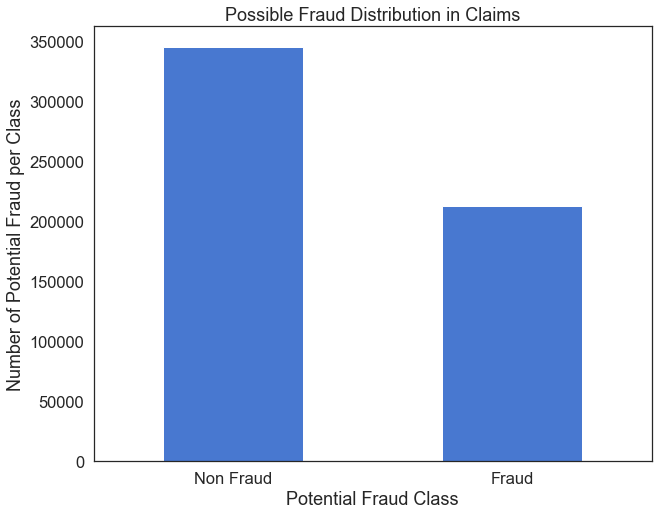

In [39]:
#i want to look at the frequency of fraud and non fraud claims within the dataset

sns.set_style('white', rc={'figure.figsize': (10, 8)})
count_classes = pd.value_counts(train_all_data['PotentialFraud'], sort=True)
print('Percentage Distribution of Potential Fraud Class:- \n', count_classes*100/len(train_all_data))
Labels = ['Non Fraud', 'Fraud']

#the bar plot
count_classes.plot(kind='bar', rot=0, figsize=(10,8))

plt.title("Possible Fraud Distribution in Claims")
plt.xticks(range(2), Labels)
plt.xlabel("Potential Fraud Class")
plt.ylabel("Number of Potential Fraud per Class")

plt.savefig('PotentialFraudDistribution')

There is a high amount of potential fraud

In [40]:
print('Non Fraud and Fraud Class Distributiuon :\n',count_classes/len(train_all_data)*100)

Non Fraud and Fraud Class Distributiuon :
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


In [41]:
print('Non Fraud and Fraud Class Percentage :/n', count_classes/len(train)*100)

Non Fraud and Fraud Class Percentage :/n No     6384.750462
Yes    3933.382625
Name: PotentialFraud, dtype: float64


Percent Distribution of Beneficiaries per state:- 
 5     8.698288
10    7.052022
45    6.336788
33    6.093565
39    4.370074
14    4.274806
36    3.872802
23    3.820116
34    3.340887
31    2.976414
11    2.808973
49    2.614827
44    2.446664
22    2.386039
15    2.361500
26    2.243136
50    2.015791
52    1.921245
1     1.887324
21    1.854846
42    1.821646
18    1.818037
3     1.728543
24    1.562545
19    1.442016
37    1.390052
4     1.311383
6     1.304166
16    1.260140
25    1.170646
7     1.156211
38    1.059499
17    0.966396
54    0.892780
51    0.874737
20    0.671930
28    0.653166
32    0.645948
46    0.614192
29    0.542741
30    0.528306
13    0.495828
27    0.388291
12    0.349317
43    0.335604
41    0.316118
8     0.299518
47    0.295909
35    0.219406
53    0.212910
9     0.154450
2     0.141459
Name: State, dtype: float64


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (6).

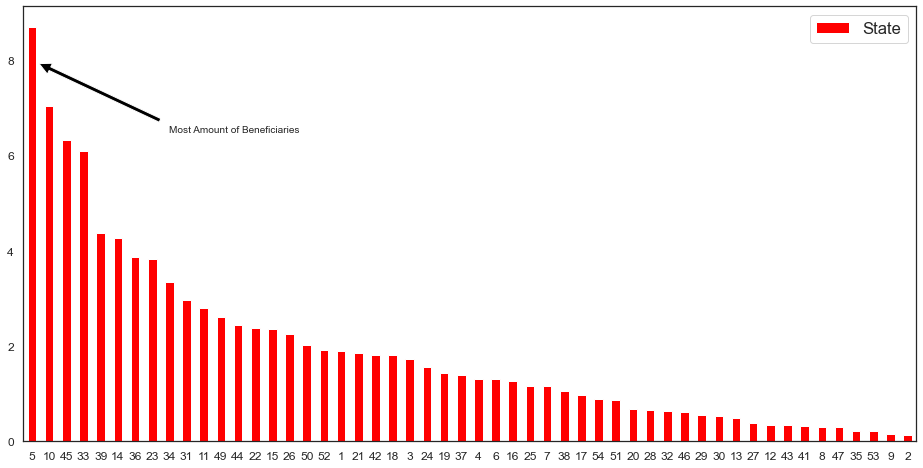

In [42]:
#I'd like to look at the frequencies of statewise beneficiaries
state_frequency = pd.value_counts(train_beneficiary['State'], sort =True)
print('Percent Distribution of Beneficiaries per state:- \n', state_frequency*100/len(train_beneficiary))

#visualisation
(state_frequency*100/len(train_beneficiary)).plot(kind='bar',color='red', rot=0, figsize=(16, 8), fontsize=12, legend=True)
plt.annotate('Most Amount of Beneficiaries', xy=(0.01, 8), xytext=(8, 6.5), arrowprops=dict(facecolor='black', shrink=.05))
plt.yticks(np.arange(0, 10, 2), ('0%', '2%', '4%', '6%', '8%', '10%'))
plt.title('Statewise Beneficiary Distribution Plot', fontsize=14)
plt.xlabel('State Number', fontsize=12)
plt.ylabel('Percentage of Beneficiaries', fontsize=12)
plt.show()

plt.savefig('StateWiseBenDistribution')

As we can see 5, 20, 45, 33, 39, 14, 36 are the top states in terms of beneficiary percentage. This probably means that these states have more people who use Medicare

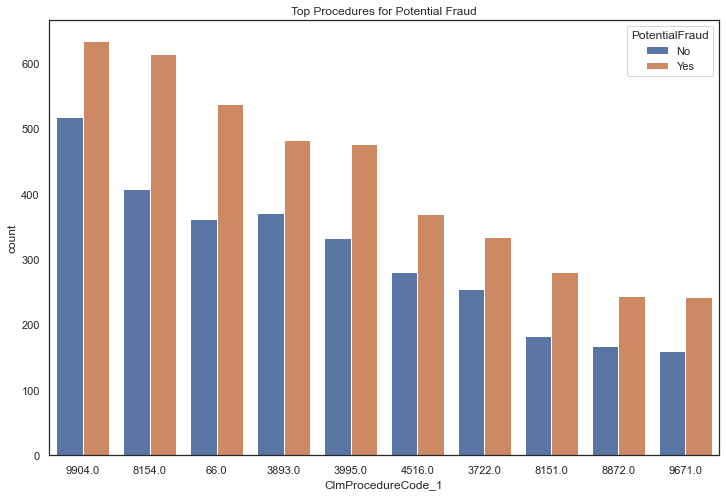

<Figure size 864x576 with 0 Axes>

In [43]:
#It's also important to look at which procedures tend to have the most fraud
sns.set(rc={'figure.figsize':(12, 8)}, style='white')
ax=sns.countplot(x='ClmProcedureCode_1', hue='PotentialFraud', data=train_all_data, order =train_all_data.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top Procedures for Potential Fraud')
plt.show()
plt.savefig('TopProceduresforPotentialFraud')

The above procedures are all written with a specific code. These codes are not specificed within the dataset but we can see the obvious the left side of the graph depicts the procedures/tests with the highest likelihood of a fraudulent claim


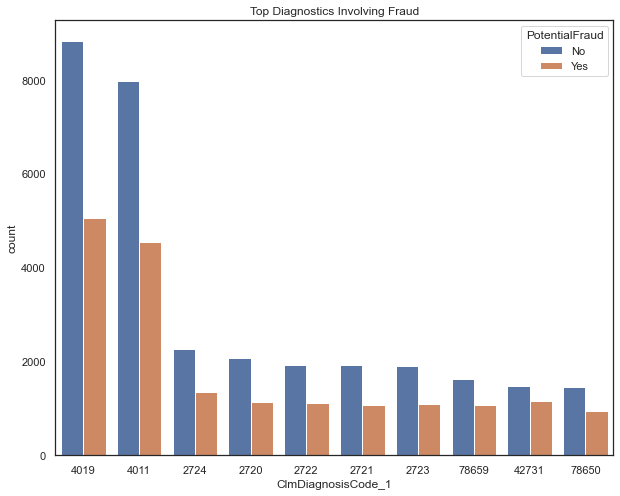

<Figure size 720x576 with 0 Axes>

In [44]:
#let's have a look at claims actually involved with fraud
sns.set(rc={'figure.figsize':(10, 8)}, style='white')
sns.countplot(x='ClmDiagnosisCode_1', hue='PotentialFraud', data=train_all_data, order=train_all_data.ClmDiagnosisCode_1.value_counts().iloc[:10].index)
plt.title('Top Diagnostics Involving Fraud')
plt.show()
plt.savefig('TopDiagnosticFraud')

From the graph above we can see the top fraudulent diagnositics are within 4019, 4011, 2724. I would try to reduce these down. We will be conducting some tests below to see if we can reduce this or detect them earlier 

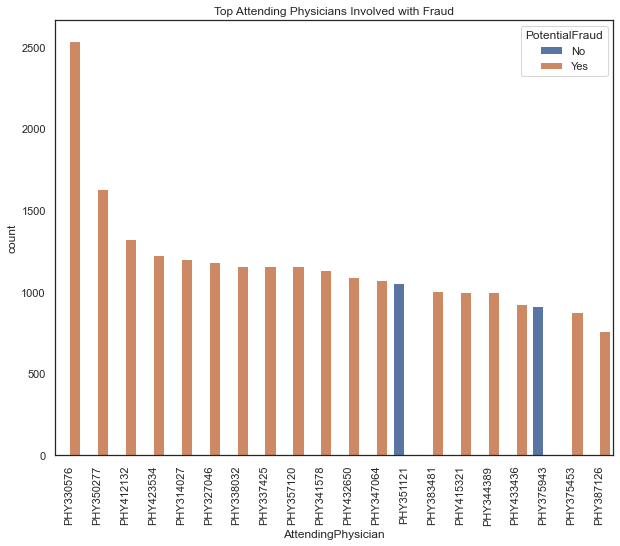

<Figure size 720x576 with 0 Axes>

In [45]:
#We can even go as far as looking at Doctor IDs to identify which doctors participate in fraudulent activity
sns.set(rc={'figure.figsize':(10,8)}, style='white')
ax=sns.countplot(x='AttendingPhysician', hue='PotentialFraud', data=train_all_data, order=train_all_data.AttendingPhysician.value_counts().iloc[:20].index)
plt.title('Top Attending Physicians Involved with Fraud')
plt.xticks(rotation=90)
plt.show()
plt.savefig('TopAttendingPhysiciansInvolvedFraud')

Within the healtchare industry it is super important to monitor and evaluate these Physicians. 

Deductibles/Reimbursements are also another form of fraud. In America annual deductibles are usually a lump some payment to pay and then anything after that is covered by insurance. Let's have a look at the potential fraud in deductibles and reimbursements. 

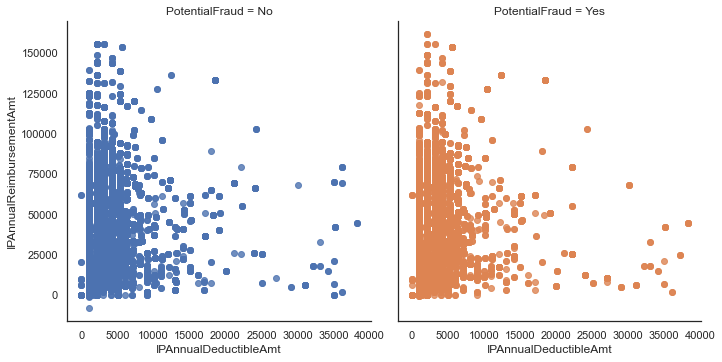

In [46]:
sns.set(rc={'figure.figsize':(10,8)}, style='white')
sns.lmplot(x='IPAnnualDeductibleAmt', y='IPAnnualReimbursementAmt', hue='PotentialFraud', col='PotentialFraud', fit_reg=False, data=train_all_data)
plt.savefig('IPAnnualDeductibleandReimbursmentAmtFraud')

There is no visible difference in Deductibles and Reimbursements

We should have a look at whether age plays a role in fraud with reimbursment claims

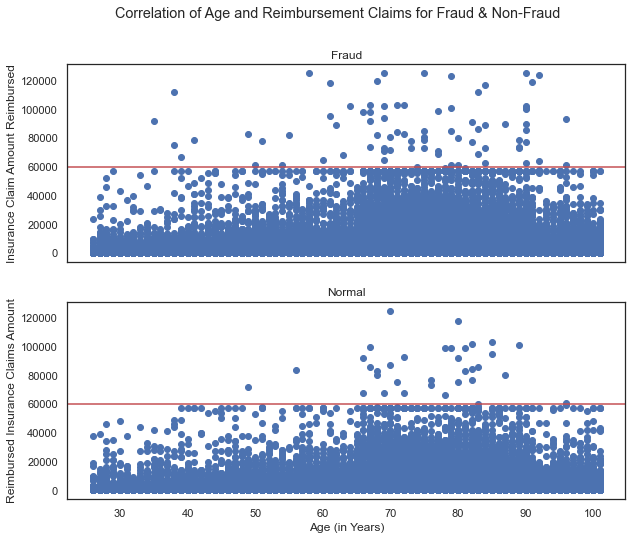

In [47]:
sns.set(rc={'figure.figsize':(10, 8)}, style='white')
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Correlation of Age and Reimbursement Claims for Fraud & Non-Fraud')
ax1.scatter(train_all_data[train_all_data.PotentialFraud=='Yes'].Age, train_all_data[train_all_data.PotentialFraud=='Yes'].InscClaimAmtReimbursed)

ax1.set_title('Fraud')
ax1.axhline(y=60000, c='r')
ax1.set_ylabel('Insurance Claim Amount Reimbursed')

ax2.scatter(train_all_data[train_all_data.PotentialFraud=='No'].Age, train_all_data[train_all_data.PotentialFraud=='No'].InscClaimAmtReimbursed)
ax2.set_title('Normal')
ax2.axhline(y=60000, c='r')
ax2.set_xlabel('Age (in Years)')
ax2.set_ylabel('Reimbursed Insurance Claims Amount')

plt.show()
f.savefig('AgeVsClaimAmtReimbursed')

There is definitely more fraud that exists within the older community. This graph depicts that younger claimants make less fraudulent claims with Reimbursements. This also shows that Age is a big factor when it comes to fraudulent claims. 

## Feature Engineering 

We need to check the last records of the test and train data

In [48]:
test_all_data.iloc[[135391]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead
135391,PRV57750,BENE150236,CLM675578,2009-11-10,2009-11-10,200,PHY323525,PHY323525,PHY323525,4788,...,1,0,0,0,0,0,290,1120,67.0,0.0


In [49]:
train_all_data.iloc[[558210]]

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt_x,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead
558210,PRV57763,No,BENE158531,CLM701529,2009-11-26,2009-11-26,40,PHY321072,NaN,PHY321072,...,1,0,0,0,0,0,3700,240,58.0,0.0


We could keep both of these data frames separate. That would work well, but I feel that it may improve accuracy of our features if we combine both test and train sets. 

In [50]:
#create copy of sets before merging
test_all_data_copy = test_all_data

In [51]:
#print shape of copy
print('Copy of Test All Data Shape :-', test_all_data_copy.shape)

Copy of Test All Data Shape :- (135392, 58)


In [52]:
#concat two datasets using the columns of Test Data, there doesn't seem to be a target column
merge_columns = test_all_data.columns

In [53]:
#now add test and train sets together
test_all_data = pd.concat([test_all_data, train_all_data[merge_columns]])

In [54]:
#verify shape after concatenating both sets
print('Shape of Test', test_all_data.shape)
print("Expected rows after adding them together", 135392+558211)

Shape of Test (693603, 58)
Expected rows after adding them together 693603


We have gotten a general sense of the data set of general ways to detect fraud. There are other ways in which we can detect fraud. We can use other methods such as grouping claimaants together based on similar behaviours. This can be done by grouping Codes, diagnosis and providers together. 

In [55]:
#Let's do average features that are based on grouping variables. Let's group them by provider
train_all_data['PerProviderAvg_InscClaimAmtReimbursed']=train_all_data.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerProviderAvg_DeductibleAmtPaid']=train_all_data.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerProviderAvg_IPAnnualReimbursementAmt']=train_all_data.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerProviderAvg_IPAnnualDeductibleAmt']=train_all_data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerProviderAvg_OPAnnualReimbursementAmt']=train_all_data.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerProviderAvg_Age']=train_all_data.groupby('Provider')['Age'].transform('mean')  
train_all_data['PerProviderAvg_NoOfMonths_PartACov']=train_all_data.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
train_all_data['PerProviderAvg_NoOfMonths_PartBCov']=train_all_data.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')               
train_all_data['PerProviderAvg_AdmitForDays']=train_all_data.groupby('Provider')['DaysAdmitted'].transform('mean')            
               
               
               
test_all_data['PerProviderAvg_InscClaimAmtReimbursed']=test_all_data.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerProviderAvg_DeductibleAmtPaid']=test_all_data.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerProviderAvg_IPAnnualReimbursementAmt']=test_all_data.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerProviderAvg_IPAnnualDeductibleAmt']=test_all_data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerProviderAvg_OPAnnualReimbursementAmt']=test_all_data.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerProviderAvg_Age']=test_all_data.groupby('Provider')['Age'].transform('mean')  
test_all_data['PerProviderAvg_NoOfMonths_PartACov']=test_all_data.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
test_all_data['PerProviderAvg_NoOfMonths_PartBCov']=test_all_data.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')               
test_all_data['PerProviderAvg_AdmitForDays']=test_all_data.groupby('Provider')['DaysAdmitted'].transform('mean')                  
               
         
               
               

In [56]:
#I am going to check the shape again
print('Train', train_all_data.shape)
train_all_data.iloc[:,-10:].head(2)

print('Test', test_all_data.shape)
test_all_data.iloc[:,-10:].head(4)

Train (558211, 68)
Test (693603, 67)


,IsDead,PerProviderAvg_InscClaimAmtReimbursed,PerProviderAvg_DeductibleAmtPaid,PerProviderAvg_IPAnnualReimbursementAmt,PerProviderAvg_IPAnnualDeductibleAmt,PerProviderAvg_OPAnnualReimbursementAmt,PerProviderAvg_Age,PerProviderAvg_NoOfMonths_PartACov,PerProviderAvg_NoOfMonths_PartBCov,PerProviderAvg_AdmitForDays
0,0.0,262.390244,1.853659,5180.926829,548.253659,2345.073171,72.365854,11.82439,12.0,NaN
1,0.0,262.390244,1.853659,5180.926829,548.253659,2345.073171,72.365854,11.82439,12.0,NaN
2,0.0,262.390244,1.853659,5180.926829,548.253659,2345.073171,72.365854,11.82439,12.0,NaN
3,0.0,262.390244,1.853659,5180.926829,548.253659,2345.073171,72.365854,11.82439,12.0,NaN


In [57]:
#The next groupby I will do is to groupby beneficiary IDs to amounts for both train and test

train_all_data['PerBeneIDAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerBeneIDAvg_DeductibleAmtPaid'] = train_all_data.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerBeneIDAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerBeneIDAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerBeneIDAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerBeneIDAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerBeneIDAvg_AdmitForDays'] = train_all_data.groupby('BeneID')['DaysAdmitted'].transform('mean')



test_all_data['PerBeneIDAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerBeneIDAvg_DeductibleAmtPaid'] = test_all_data.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerBeneIDAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerBeneIDAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerBeneIDAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerBeneIDAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerBeneIDAvg_AdmitForDays'] = test_all_data.groupby('BeneID')['DaysAdmitted'].transform('mean')




In [58]:
#Taking the averages and grouping them by Physicians

train_all_data['PerOtherPhysicianAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerOtherPhysicianAvg_DeductibleAmtPaid'] = train_all_data.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerOtherPhysicianAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerOtherPhysicianAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerOtherPhysicianAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerOtherPhyisicianAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerOtherPhyisicianAvg_AdmitForDays'] = train_all_data.groupby('OtherPhysician')['DaysAdmitted'].transform('mean')


test_all_data['PerOtherPhysicianAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerOtherPhysicianAvg_DeductibleAmtPaid'] = test_all_data.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerOtherPhysicianAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerOtherPhysicianAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerOtherPhysicianAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerOtherPhyisicianAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerOtherPhyisicianAvg_AdmitForDays'] = test_all_data.groupby('OtherPhysician')['DaysAdmitted'].transform('mean')




In [59]:
#taking the averges and grouping them by Operating Physicians

train_all_data['PerOperatingPhysicianAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerOperatingPhysicianAvg_DeductibleAmtPaid'] = train_all_data.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerOperatingPhysicianAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerOperatingPhysicianAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerOperatingPhysicianAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerOperatingPhyisicianAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerOperatingPhyisicianAvg_AdmitForDays'] = train_all_data.groupby('OperatingPhysician')['DaysAdmitted'].transform('mean')


test_all_data['PerOperatingPhysicianAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerOperatingPhysicianAvg_DeductibleAmtPaid'] = test_all_data.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerOperatingPhysicianAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerOperatingPhysicianAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerOpertatingPhysicianAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerOperatingPhyisicianAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerOperatingPhyisicianAvg_AdmitForDays'] = test_all_data.groupby('OperatingPhysician')['DaysAdmitted'].transform('mean')


In [60]:
#taking the averges and grouping them by Attending Physicians

train_all_data['PerAttendingPhysicianAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerAttendingPhysicianAvg_DeductibleAmtPaid'] = train_all_data.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerAttendingPhysicianAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerAttendingPhysicianAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerAttendingPhysicianAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerAttendingPhyisicianAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerAttendingPhyisicianAvg_AdmitForDays'] = train_all_data.groupby('AttendingPhysician')['DaysAdmitted'].transform('mean')


test_all_data['PerAttendingPhysicianAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerAttendingPhysicianAvg_DeductibleAmtPaid'] = test_all_data.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerAttendingPhysicianAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerAttendinggPhysicianAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerAttendingPhysicianAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerAttendingPhyisicianAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerAttendingPhyisicianAvg_AdmitForDays'] = test_all_data.groupby('AttendingPhysician')['DaysAdmitted'].transform('mean')


In [61]:
#taking the average and grouping them by Diagnosis Group Codes
train_all_data['PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_DeductibleAmtPaid'] = train_all_data.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerDiagnosisGroupCodeAvg_AdmitForDays'] = train_all_data.groupby('DiagnosisGroupCode')['DaysAdmitted'].transform('mean')


test_all_data['PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_DeductibleAmtPaid'] = test_all_data.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerDiagnosisGroupCodeAvg_AdmitForDays'] = test_all_data.groupby('DiagnosisGroupCode')['DaysAdmitted'].transform('mean')



In [62]:
#taking the average and grouping them by Claim Admit Diagnosis Code
train_all_data['PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmAdmitDiagnosisCodeAvg_AdmitForDays'] = train_all_data.groupby('ClmAdmitDiagnosisCode')['DaysAdmitted'].transform('mean')


test_all_data['PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmAdmitDiagnosisCodeAvg_AdmitForDays'] = test_all_data.groupby('ClmAdmitDiagnosisCode')['DaysAdmitted'].transform('mean')



In [63]:
#taking the average and grouping them by Claim Procedure Code
train_all_data['PerClmProcedureCode_1Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_1Avg_AdmitForDays'] = train_all_data.groupby('ClmProcedureCode_1')['DaysAdmitted'].transform('mean')


test_all_data['PerClmProcedureCode_1Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_1Avg_AdmitForDays'] = test_all_data.groupby('ClmProcedureCode_1')['DaysAdmitted'].transform('mean')



In [64]:
#taking the average and grouping them by Claim Procedure Code 2
train_all_data['PerClmProcedureCode_2Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_2Avg_AdmitForDays'] = train_all_data.groupby('ClmProcedureCode_2')['DaysAdmitted'].transform('mean')


test_all_data['PerClmProcedureCode_2Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_2Avg_AdmitForDays'] = test_all_data.groupby('ClmProcedureCode_2')['DaysAdmitted'].transform('mean')



In [65]:
#taking the average and grouping them by Claim Procedure Code 3
train_all_data['PerClmProcedureCode_3Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmProcedureCode_3Avg_AdmitForDays'] = train_all_data.groupby('ClmProcedureCode_3')['DaysAdmitted'].transform('mean')


test_all_data['PerClmProcedureCode_3Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmProcedureCode_3Avg_AdmitForDays'] = test_all_data.groupby('ClmProcedureCode_3')['DaysAdmitted'].transform('mean')



In [66]:
#taking the average and grouping them by Claim Diagnosis Code 1
train_all_data['PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_1Avg_AdmitForDays'] = train_all_data.groupby('ClmDiagnosisCode_1')['DaysAdmitted'].transform('mean')


test_all_data['PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_1Avg_AdmitForDays'] = test_all_data.groupby('ClmDiagnosisCode_1')['DaysAdmitted'].transform('mean')



In [67]:
#taking the average and grouping them by Claim Diagnosis Code 2
train_all_data['PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_2Avg_AdmitForDays'] = train_all_data.groupby('ClmDiagnosisCode_2')['DaysAdmitted'].transform('mean')


test_all_data['PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_2Avg_AdmitForDays'] = test_all_data.groupby('ClmDiagnosisCode_2')['DaysAdmitted'].transform('mean')



In [68]:
#taking the average and grouping them by Claim Diagnosis Code 3
train_all_data['PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_3Avg_AdmitForDays'] = train_all_data.groupby('ClmDiagnosisCode_3')['DaysAdmitted'].transform('mean')


test_all_data['PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_3Avg_AdmitForDays'] = test_all_data.groupby('ClmDiagnosisCode_3')['DaysAdmitted'].transform('mean')


In [69]:
#taking the average and grouping them by Claim Diagnosis Code 4
train_all_data['PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed'] = train_all_data.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_DeductibleAmtPaid'] = train_all_data.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt'] = train_all_data.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt'] = train_all_data.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
train_all_data['PerClmDiagnosisCode_4Avg_AdmitForDays'] = train_all_data.groupby('ClmDiagnosisCode_4')['DaysAdmitted'].transform('mean')


test_all_data['PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed'] = test_all_data.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_DeductibleAmtPaid'] = test_all_data.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt'] = test_all_data.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt'] = test_all_data.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
test_all_data['PerClmDiagnosisCode_4Avg_AdmitForDays'] = test_all_data.groupby('ClmDiagnosisCode_4')['DaysAdmitted'].transform('mean')


Detecting fraud is super important. It can happen in various different ways. For this reason I am going to combine various attributes and group them together to see if there is a strong correlation. 

In [72]:
train_all_data['ClmCount_Provider'] = train_all_data.groupby(['Provider'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID'] = train_all_data.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_AttendingPhysician'] = train_all_data.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_OtherPhysician'] = train_all_data.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_OperatingPhysician'] = train_all_data.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')

train_all_data['ClmCount_Provider_ClmAdmitDiagnosisCode'] = train_all_data.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmProcedureCode_2'] = train_all_data.groupby(['Provider', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmProcedureCode_3'] = train_all_data.groupby(['Provider', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmProcedureCode_4'] = train_all_data.groupby(['Provider', 'ClmProcedureCode_4'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmProcedureCode_5'] = train_all_data.groupby(['Provider', 'ClmProcedureCode_5'])['ClaimID'].transform('count')

train_all_data['ClmCount_Provider_ClmDiagnosisCode_1'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_2'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_3'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_4'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_5'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_6'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_7'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_8'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_ClmDiagnosisCode_9'] = train_all_data.groupby(['Provider', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')

train_all_data['ClmCount_Provider_DiagnosisGroupCode'] = train_all_data.groupby(['Provider', 'DiagnosisGroupCode'])['ClaimID'].transform('count')

train_all_data['ClmCount_Provider_BeneID_AttendingPhysician'] = train_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_OtherPhysician'] = train_all_data.groupby(['Provider', 'BeneID', 'OtherPhysician'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1'] = train_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1'] = train_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_OperatingPhysician'] = train_all_data.groupby(['Provider', 'BeneID', 'OperatingPhysician'])['ClaimID'].transform('count')
                                                                                 
train_all_data['ClmCount_Provider_BeneID_ClmProcedure_1'] = train_all_data.groupby(['Provider', 'BeneID', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_ClmDiagnosisCode_1'] = train_all_data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_all_data['ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1'] = train_all_data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')


test_all_data['ClmCount_Provider'] = test_all_data.groupby(['Provider'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID'] = test_all_data.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_AttendingPhysician'] = test_all_data.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_OtherPhysician'] = test_all_data.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_OperatingPhysician'] = test_all_data.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')

test_all_data['ClmCount_Provider_ClmAdmitDiagnosisCode'] = test_all_data.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmProcedureCode_2'] = test_all_data.groupby(['Provider', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmProcedureCode_3'] = test_all_data.groupby(['Provider', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmProcedureCode_4'] = test_all_data.groupby(['Provider', 'ClmProcedureCode_4'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmProcedureCode_5'] = test_all_data.groupby(['Provider', 'ClmProcedureCode_5'])['ClaimID'].transform('count')

test_all_data['ClmCount_Provider_ClmDiagnosisCode_1'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_2'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_3'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_4'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_5'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_6'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_7'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_8'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_ClmDiagnosisCode_9'] = test_all_data.groupby(['Provider', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')

test_all_data['ClmCount_Provider_DiagnosisGroupCode'] = test_all_data.groupby(['Provider', 'DiagnosisGroupCode'])['ClaimID'].transform('count')

test_all_data['ClmCount_Provider_BeneID_AttendingPhysician'] = test_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_OtherPhysician'] = test_all_data.groupby(['Provider', 'BeneID', 'OtherPhysician'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1'] = test_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1'] = test_all_data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_OperatingPhysician'] = test_all_data.groupby(['Provider', 'BeneID', 'OperatingPhysician'])['ClaimID'].transform('count')
                                                                                 
test_all_data['ClmCount_Provider_BeneID_ClmProcedure_1'] = test_all_data.groupby(['Provider', 'BeneID', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_ClmDiagnosisCode_1'] = test_all_data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
test_all_data['ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1'] = test_all_data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')















In [73]:
# It's important to keep checking the shape after adding features
print('Train All Data Shape-', train_all_data.shape)
print('Test All Data Shape-', test_all_data.shape)

Train All Data Shape- (558211, 186)
Test All Data Shape- (693603, 186)


In [74]:
# Check to see the unique values of Diagnosis Codes
unique_diagnosis = train_all_data['ClmDiagnosisCode_1'].astype(str).str[0:2]

unique_diagnosis.unique()

array(['59', '78', 'V4', '29', '03', '51', 'na', '71', 'V1', '27', '42',
       'V7', '24', '41', '56', '79', '04', '35', '85', 'V5', '72', '44',
       '45', '18', '60', '50', '57', '40', '16', '25', '68', '15', '82',
       '28', '61', '47', '99', '20', '70', '33', '31', '49', '88', '48',
       '53', '43', '91', '55', '00', '58', '73', '46', '19', '17', 'V0',
       '34', 'V6', '62', 'V8', '11', '36', '83', 'E8', '02', '32', '52',
       '38', '23', '84', '37', 'V2', '87', '30', '90', '21', '12', '92',
       '39', '63', '69', '64', '81', '89', '95', '80', '22', '07', '06',
       '93', '94', '54', '26', '05', '13', '74', '14', '98', '08', '97',
       '75', '66', 'E9', '09', '96', '10', '77', '86', '65', '67', '01',
       '76'], dtype=object)

I have taken the first to numbers which are now seen as strings of the diangosis codes. I have done this in order to create a large sparse matrix, this will create code columns and will help to compute dummy columns. This will help to increase computational abilities. 

In [75]:
#It's now important to impute numeric columns with 0

code_col_1 = train_all_data.select_dtypes([np.number]).columns
code_col_2 = train_all_data.select_dtypes([np.number]).columns

train_all_data[code_col_1] = train_all_data[code_col_1].fillna(value=0)
train_all_data[code_col_2] = train_all_data[code_col_2].fillna(value=0)

print('Test All Data Shape:', test_all_data.shape)

Test All Data Shape: (693603, 186)


In [87]:
#Now I am going to remove the columns that I find to be unnecessary. 

columns = train_all_data.columns
columns[:58]

remove_columns = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt_x', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
                 'ClmAdmitDiagnosisCode', 'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'DOB', 'DOD', 'State', 'County']
train_categories_removed = train_all_data.drop(axis=1, columns = remove_columns)
test_categories_removed = test_all_data.drop(axis=1, columns = remove_columns)

In [88]:
#checking for missing values
print('Train Shape :', train_categories_removed.shape)
print('Train Missing Values:', train_categories_removed.isnull().sum().sum())
print('Test Shape:', test_categories_removed.shape)
print('Test Missing Values:', test_categories_removed.isnull().sum().sum())

Train Shape : (558211, 155)
Train Missing Values: 517737
Test Shape: (693603, 155)
Test Missing Values: 52997001


I have done something wrong...

In [89]:
#It's important to convert other variables into categorical data
train_categories_removed.Gender = train_categories_removed.Gender.astype('category')
test_categories_removed.Gender = test_categories_removed.Gender.astype('category')

train_categories_removed.Race = train_categories_removed.Race.astype('category')
test_categories_removed.Race = test_categories_removed.Race.astype('category')

In [90]:
#Lets dummify! Need to convert this to dummy variables
train_categories_removed = pd.get_dummies(train_categories_removed, columns = ['Gender', 'Race'], drop_first=True)
test_categories_removed = pd.get_dummies(test_categories_removed, columns = ['Gender', 'Race'], drop_first=True)

In [92]:
#Lets make sure I have successfully created dummies
train_categories_removed.head().T
test_categories_removed.iloc[135391:135393]

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimEndDt_y,DaysAdmitted,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedure_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
135391,PRV57750,200,0.0,NaN,NaN,0,12,12,0,1,...,NaN,1.0,1.0,NaN,1.0,NaN,1,0,1,0
0,PRV51001,20,0.0,NaN,NaN,1,12,12,1,1,...,NaN,1.0,NaN,NaN,1.0,NaN,0,0,0,0


In [93]:
#Now I need to convert target values to 0 and 1, 0 = no 1 = yes
train_categories_removed.PotentialFraud.replace(['Yes','No'], ['1', '0'], inplace=True)
train_categories_removed.head()
train_categories_removed.PotentialFraud = train_categories_removed.PotentialFraud.astype('int64')
train_categories_removed.PotentialFraud.dtypes
train_categories_removed.PotentialFraud.min()

0

In [94]:
train_categories_removed.PotentialFraud.max()

1

In [95]:
#Test related data from the concatted datasets
print('Test Shape Before Removing Columns', test_categories_removed.shape)


Test Shape Before Removing Columns (693603, 157)


In [96]:
test_categories_removed = test_categories_removed.iloc[:135392]

In [97]:
#check 
test_categories_removed.tail()

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimEndDt_y,DaysAdmitted,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedure_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
135387,PRV57750,1300,0.0,NaN,NaN,0,12,12,0,1,...,NaN,1.0,NaN,NaN,1.0,NaN,1,0,0,0
135388,PRV57750,10,0.0,NaN,NaN,0,12,12,0,0,...,NaN,1.0,NaN,NaN,1.0,NaN,1,0,0,0
135389,PRV57750,200,0.0,NaN,NaN,0,12,12,0,0,...,NaN,1.0,NaN,NaN,1.0,NaN,1,1,0,0
135390,PRV57750,2300,0.0,NaN,NaN,0,12,12,1,0,...,NaN,1.0,1.0,NaN,1.0,NaN,1,0,0,0
135391,PRV57750,200,0.0,NaN,NaN,0,12,12,0,1,...,NaN,1.0,1.0,NaN,1.0,NaN,1,0,1,0


In [101]:
# Aggregate to Providers Level, this should be unique to the providers
train_categories_removed_providers = train_categories_removed.groupby(['Provider', 'PotentialFraud'], as_index = False).agg('sum')
test_categories_removed_providers = test_categories_removed.groupby(['Provider'], as_index = False).agg('sum')


In [102]:
print('Train Providers:', train_categories_removed_providers.shape)
print('Test Providers:', test_categories_removed_providers.shape)

Train Providers: (5410, 155)
Test Providers: (1353, 155)


In [103]:
train_categories_removed_providers.head()

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,DaysAdmitted,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedure_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,300,300,15,19,17,...,2.0,24.0,5.0,2.0,24.0,2.0,16.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,382.0,1560,1567,56,80,64,...,39.0,132.0,45.0,39.0,132.0,39.0,78.0,24.0,0.0,1.0
2,PRV51004,0,52170,310.0,0.0,1768,1782,64,88,50,...,0.0,143.0,27.0,0.0,143.0,0.0,103.0,24.0,5.0,0.0
3,PRV51005,1,280910,3700.0,0.0,13872,13910,426,680,507,...,0.0,1151.0,264.0,0.0,1171.0,0.0,654.0,262.0,10.0,0.0
4,PRV51007,0,33710,3264.0,19.0,852,852,26,40,22,...,1.0,72.0,12.0,1.0,72.0,1.0,38.0,14.0,0.0,0.0


In [104]:
test_categories_removed_providers.head()

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,DaysAdmitted,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedure_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51002,53790,380.0,0.0,2424,2460,79,108,72,25,...,0.0,202.0,30.0,0.0,204.0,0.0,134.0,30.0,2.0,4.0
1,PRV51006,30720,0.0,0.0,1224,1224,35,69,50,15,...,0.0,99.0,26.0,0.0,99.0,0.0,59.0,26.0,0.0,0.0
2,PRV51009,27230,1238.0,8.0,468,468,8,17,19,1,...,2.0,40.0,24.0,2.0,41.0,2.0,23.0,6.0,0.0,0.0
3,PRV51010,64580,5340.0,29.0,444,444,21,23,19,7,...,3.0,38.0,9.0,3.0,38.0,3.0,15.0,1.0,0.0,0.0
4,PRV51018,61620,670.0,0.0,2232,2276,73,109,93,25,...,0.0,188.0,30.0,0.0,188.0,0.0,124.0,45.0,0.0,0.0


# Train Validation Split

In [105]:
#Start by differentiating the target and provider variables and creating a target column
x = train_categories_removed_providers.drop(axis=1, columns=['Provider', 'PotentialFraud'])
y = train_categories_removed_providers['PotentialFraud']

In [106]:
#Standardize!
standardscaler = StandardScaler() #minmax
#fit to scale
standardscaler.fit(x)

x_standardscaler = standardscaler.transform(x)

#apply scaler to all other data as well
x_test_standardscaler = test_categories_removed_providers.iloc[:, 1] 

In [107]:
print('Shape of X', x_standardscaler.shape)

Shape of X (5410, 153)


In [108]:
#split into train and validation 

X_train, X_val, y_train, y_val = train_test_split(x_standardscaler, y, test_size = .2, random_state = 3, stratify=y, shuffle= True)

In [109]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('Y_val:', y_val.shape)

X_train: (4328, 153)
y_train: (4328,)
X_val: (1082, 153)
Y_val: (1082,)


# Baseline Model

In [111]:
#We will make a baseline model using logistic regression

from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv =10, class_weight = 'balanced', random_state = 2)

#fit to scale
log.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=2, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [112]:
#predict the probability of 1 and 0 for X_train and X_val

logistic_predproba = log.predict_proba(X_train)
logistic_val_predproba = log.predict_proba(X_val)

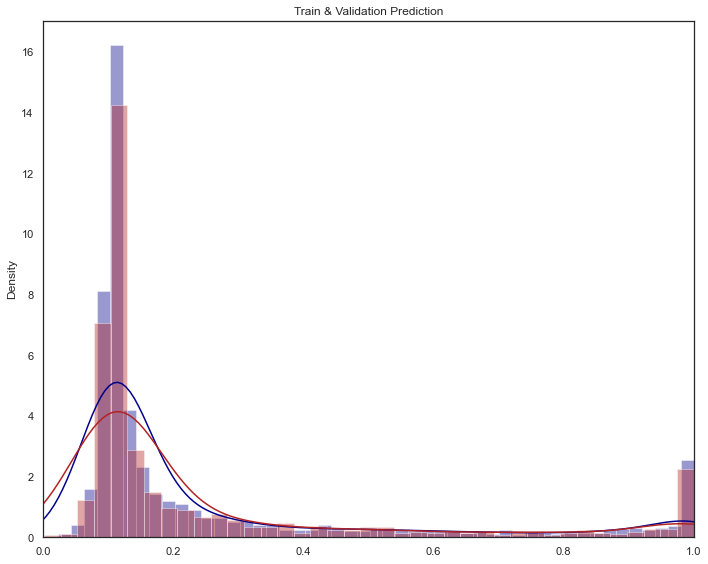

In [113]:
#Logreg model prediction for train and validation

figure = plt.figure(figsize=(10,8))

sns.distplot(log.predict_proba(X_train)[:,1], color = 'darkblue')
sns.distplot(log.predict_proba(X_val)[:,1], color='firebrick')
plt.title('Train & Validation Prediction')
plt.xlim([0,1])

plt.tight_layout()

plt.show()

IndexError: index 105 is out of bounds for axis 0 with size 102

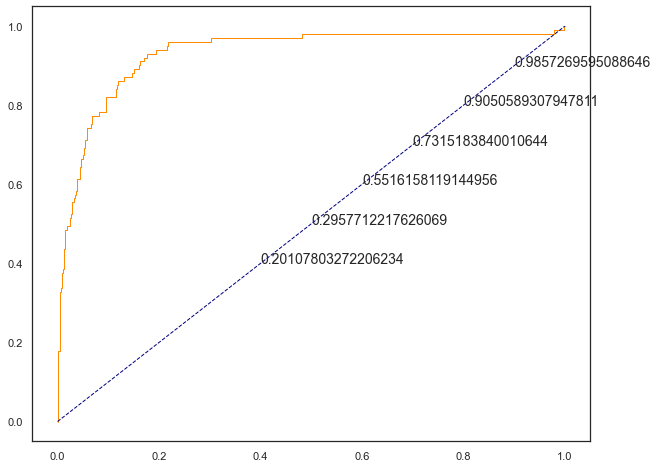

In [115]:
#Receiver Operating Characteristic

from sklearn.metrics import roc_curve, auc, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_val, log.predict_proba(X_val)[:, 1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw=1, label= 'ROC curve (AUC = %0.2f)' %roc_auc)

plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')

for label in range(1, 10, 1):
    plt.text((10-label)/10, (10-label)/10, thresholds[label*15], fontdict={'size':14})
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [117]:
#need to get the exact area under te curve 
fpr, tpr, thresholds = roc_curve(y_val, log.predict_proba(X_val)[:,1], pos_label = 1)

roc_auc = auc(fpr, tpr)
print('Area Under The ROC Curve: %f' % roc_auc)

Area Under The ROC Curve: 0.931339


This is too close to 1, I believe there is some overfitting here

Text(0.5, 1.0, 'Precision Vs Recall')

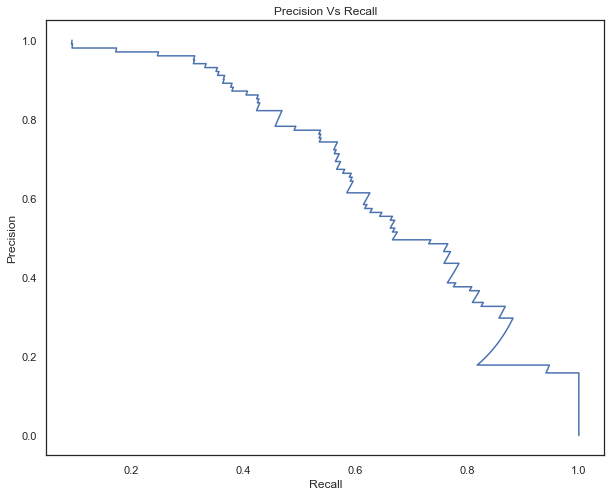

In [120]:
#logistic regression: precision vs recall curve
precision, recall, _ = precision_recall_curve(y_val, log.predict_proba(X_val)[:,1])

plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Vs Recall')